In [72]:
import csv
import random
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import impute
from sklearn import feature_selection
from sklearn import tree
from sklearn import neural_network
from sklearn import cluster
from copy import deepcopy
import seaborn as sns

def loadFile(filePath):
    dataset = []
    with open(filePath, 'r') as fd:
        header = next(fd)
        reader = csv.reader(fd, delimiter=';')
        for row in reader:
            for i in range(len(row)):
                row[i] = float(row[i])
            dataset.append(row)
    return dataset, header.replace('"', '').split(';')

def removeValues(dataset, percentage):
    copy = deepcopy(dataset)
    toRemove = int(len(dataset[0])*percentage)
    print(len(dataset), percentage, toRemove)
    for row in copy:
        for i in range(toRemove):
            feature = int(random.random() * len(row)) 
            row[feature] = np.nan
    return copy

def handleMissingValues(dataset, strat):
    imp = sk.impute.SimpleImputer(missing_values=np.nan, strategy=strat)
    return imp.fit_transform(dataset)

def applyNormalization(dataset, norm):
    return sk.preprocessing.normalize(dataset, norm=norm)

def applyDiscretization(dataset):
    transf = sk.preprocessing.KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile')
    return transf.fit_transform(dataset)

def applyDataReduction(dataset):
    agglo = sk.cluster.FeatureAgglomeration(n_clusters=5)
    return agglo.fit_transform(dataset)

def pearsonCorrelation(dataset, header, target):
    dictPearson = {}
    df = pd.DataFrame(dataset, columns = header)
    y = df[target]          #Target Variable
    X = df.drop(target, axis=1)   #Feature Matrix
    pearson = sk.feature_selection.r_regression(X, y, center=True)
    return pearson

def plotPearson(dataset, header, target, colors):
    pearson = pearsonCorrelation(dataset, header, target)
    headerPearson = deepcopy(header)
    headerPearson.remove(target)
    plt.title('Target Feature: ' + target)
    plt.barh([1,2,3,4,5,6,7,8,9,10,11], pearson, height=0.8, align='center', tick_label=headerPearson,
             color=colors)
    plt.xlim([-1,1])
    plt.show()

def plotAllPearson(dataset, header):
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(11)]
    for target in header:
        plotPearson(dataset, header, target, colors)
    
def randomColors(n):
    colors = []
    for i in range(n):
        colors.append(np.random.choice(range(256), size=3))
    print(colors)
    return colors

#podemos apagar as funções do pearson porque esta faz tudo
def correlationMatrix(df):
    corr_mat = df.corr()
    plt.figure(figsize=(13,5))
    sns_plot = sns.heatmap(data=corr_mat, annot=True, cmap='GnBu')
    plt.show()
    
def barPlotWineQuality(df):
    orderedList = []
    orderedList.append(df["wine classification"].value_counts()[2])
    orderedList.append(df["wine classification"].value_counts()[0])
    orderedList.append(df["wine classification"].value_counts()[1])
    plt.bar(x=['bad', 'medium', 'good'], height=orderedList)
    
def visualizePairOfFeatures(df, xfeature, yfeature):
    sns.set(color_codes=True)
    g = sns.lmplot(x=xfeature, y=yfeature, data=df, line_kws={'color': 'limegreen'})
    
def decisionTree(df, X, target):
    y = df[target]          #Target Variable
    clf = tree.DecisionTreeClassifier(splitter='best', max_features = 11, random_state = 1)
    clf = clf.fit(X, y)
    tree.export_graphviz(clf, out_file='tree.dot', feature_names=header[:-1], class_names=["bad","good","medium"]) 
    plt.figure(figsize=(20, 20))
    tree.plot_tree(clf, feature_names=header, class_names=["bad","good","medium"])
    #ainda só está a criar a arvore, falta por a fazer a classificação
    
def ourMLPClassifier(df, X, target):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = sk.neural_network.MLPClassifier(random_state=1, max_iter=10000).fit(X_train, y_train)
    # caso queiramos ver os resultados, dar return ao predict
    clf.predict(X_test)
    return clf.score(X_test, y_test)

def knn(df, X, target):
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=7)
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    knn.fit(X_train, y_train)

    #Predict the response for test dataset
    
    y_pred= knn.predict(X_test)
    print(y_pred)
    print("Accuracy:",sk.metrics.accuracy_score(y_test, y_pred))
    
def kMeans(df, X, target, header):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = sk.cluster.KMeans(n_clusters=3, random_state=1).fit(X_train, y_train)
    # caso queiramos ver os resultados, dar return ao predict
    y_pred = clf.predict(X_test)
    #print(sk.metrics.silhouette_samples(X_test, y_pred))
    print(sk.metrics.silhouette_score(X_test, y_pred))
    return clf.score(X_test)

def dbscan(df, X, target):
    y = df[target]
    neigh = sk.neighbors.NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    
    clf = sk.cluster.DBSCAN(eps=3, min_samples=3).fit_predict(X, y)
    # caso queiramos ver os resultados, dar return ao predict
    #clf.predict(X_test)
    return clf[:500]

def agglomerativeClustering(df, X, target):
    y = df[target]
    clf = sk.cluster.AgglomerativeClustering(n_clusters = 2).fit_predict(X, y)
    # caso queiramos ver os resultados, dar return ao predict
    #clf.predict(X_test)
    return clf[:500]
    



In [ ]:
#LOAD DATASETS

redWineData, headerRed = loadFile("./winequality-red.csv")
headerRed[11] = headerRed[11].strip('\n')

whiteWineData, headerWhite = loadFile("./winequality-white.csv")
headerWhite[11] = headerWhite[11].strip('\n')

In [ ]:
#REMOVE VALUES (ADD MISSING VALUES)

redMissing10per = removeValues(redWineData, 0.1)
redMissing20per = removeValues(redWineData, 0.2)
redMissing30per = removeValues(redWineData, 0.3)

whiteMissing10per = removeValues(redWineData, 0.1)
whiteMissing20per = removeValues(redWineData, 0.2)
whiteMissing30per = removeValues(redWineData, 0.3)

In [ ]:
#HANDLE MISSING VALUES

redMean10 = handleMissingValues(redMissing10per, 'mean')
redMean20 = handleMissingValues(redMissing20per, 'mean')
redMean30 = handleMissingValues(redMissing30per, 'mean')

whiteMostFreq10 = handleMissingValues(whiteMissing10per, 'most_frequent')
whiteMostFreq20 = handleMissingValues(whiteMissing20per, 'most_frequent')
whiteMostFreq30 = handleMissingValues(whiteMissing30per, 'most_frequent')

In [ ]:
#VINHO TINTO

dataset, header = loadFile("./winequality-red.csv")
header[11] = header[11].strip('\n')
redMissing = removeValues(dataset, 0.1)
redMissing = handleMissingValues(redMissing, 'mean')
#redMissing = handleMissingValues(redMissing, 'most_frequent')

'''
red1 = applyNormalization(dataset, 'l1')
print(red1)
red2 = applyNormalization(dataset, 'l2')
print(red2)
red3 = applyNormalization(dataset, 'max')
print(red3)

redRed = applyDataReduction(dataset)

redDisc = applyDiscretization(dataset)
'''
df = pd.DataFrame(dataset, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X = df.drop("wine classification", axis=1)
X = X.drop("quality", axis=1)

df = pd.DataFrame(redMissing, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X1 = df.drop("wine classification", axis=1)
X1 = X1.drop("quality", axis=1)

#plotAllPearson(dataset, header)

#decisionTree(df, X, "wine classification")

#ourMLPClassifier(df, X, "wine classification")

#knn(df, X, "wine classification")

#kMeans(df, X, "wine classification", header)

#dbscan(df, X, "wine classification")

#agglomerativeClustering(df, X, "wine classification")

#print(ourMLPClassifier(df, X, "wine classification"))

#print(ourMLPClassifier(df, X1, "wine classification"))

#sns_visualization = sns.pairplot(df)


#print(pearsonCorrelation(dataset, header, "fixed acidity"))

#correlationMatrix(df)

#visualizePairOfFeatures(df, "fixed acidity", "citric acid")
#visualizePairOfFeatures(df, "fixed acidity", "density")
#visualizePairOfFeatures(df, "free sulfur dioxide", "total sulfur dioxide")

barPlotWineQuality(df)


# (fixed acidity, citric acid) (density, fixed acidity) (total sulfur dioxide, free sulfur dioxide)
# (quality, alcohol)




4898 0.1 1


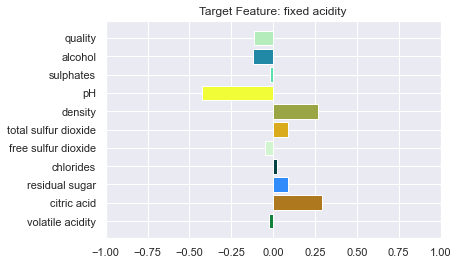

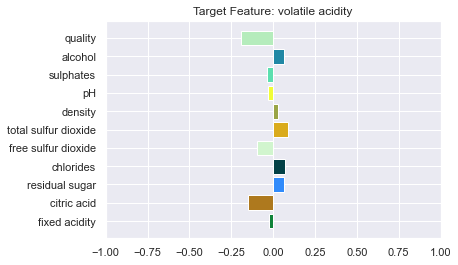

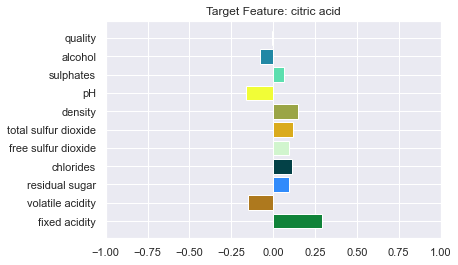

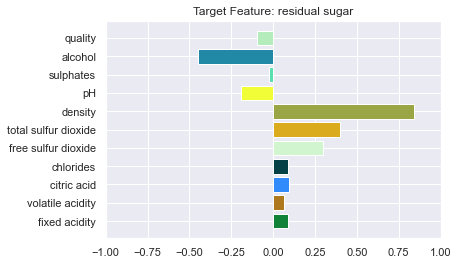

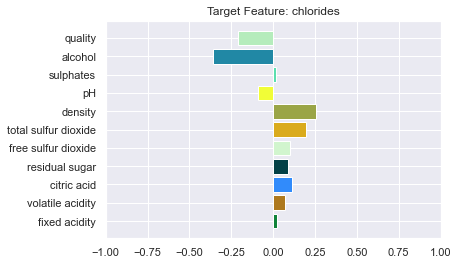

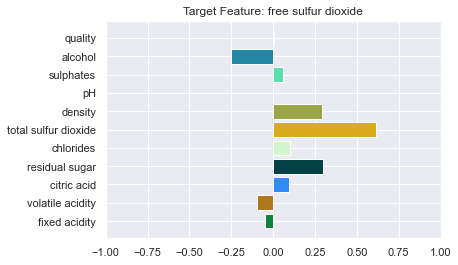

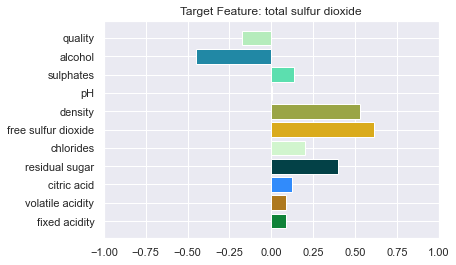

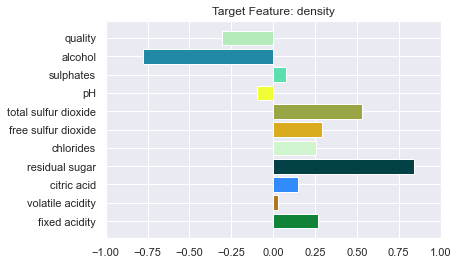

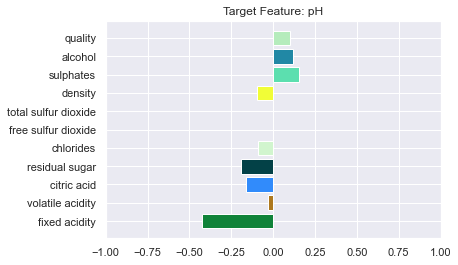

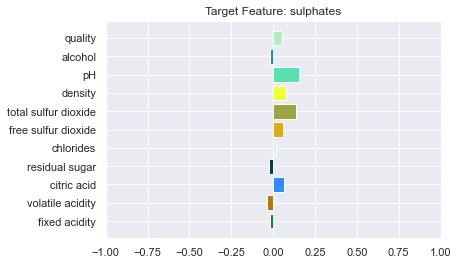

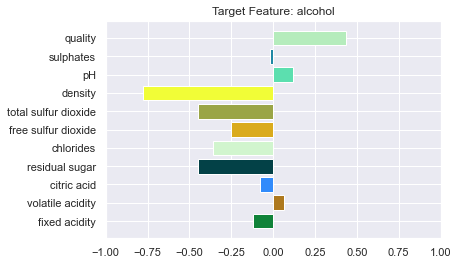

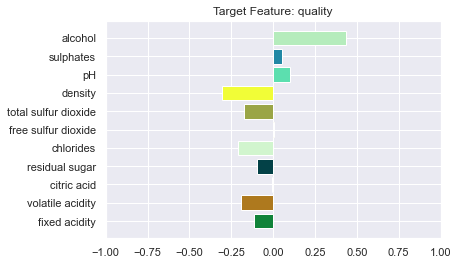

['medium' 'medium' 'medium' ... 'medium' 'medium' 'medium']
Accuracy: 0.7485714285714286
0.41037304389438795


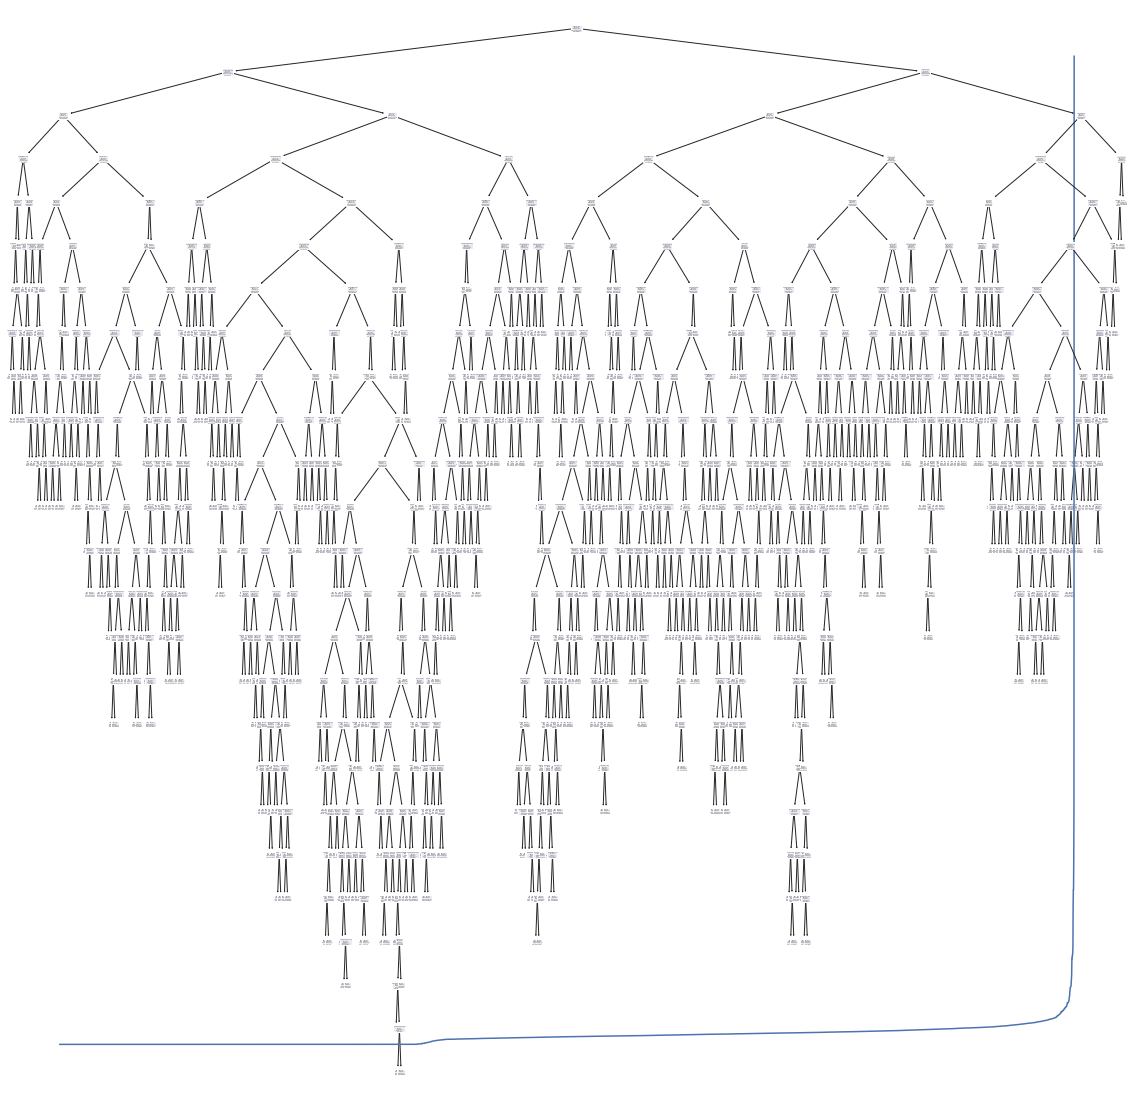

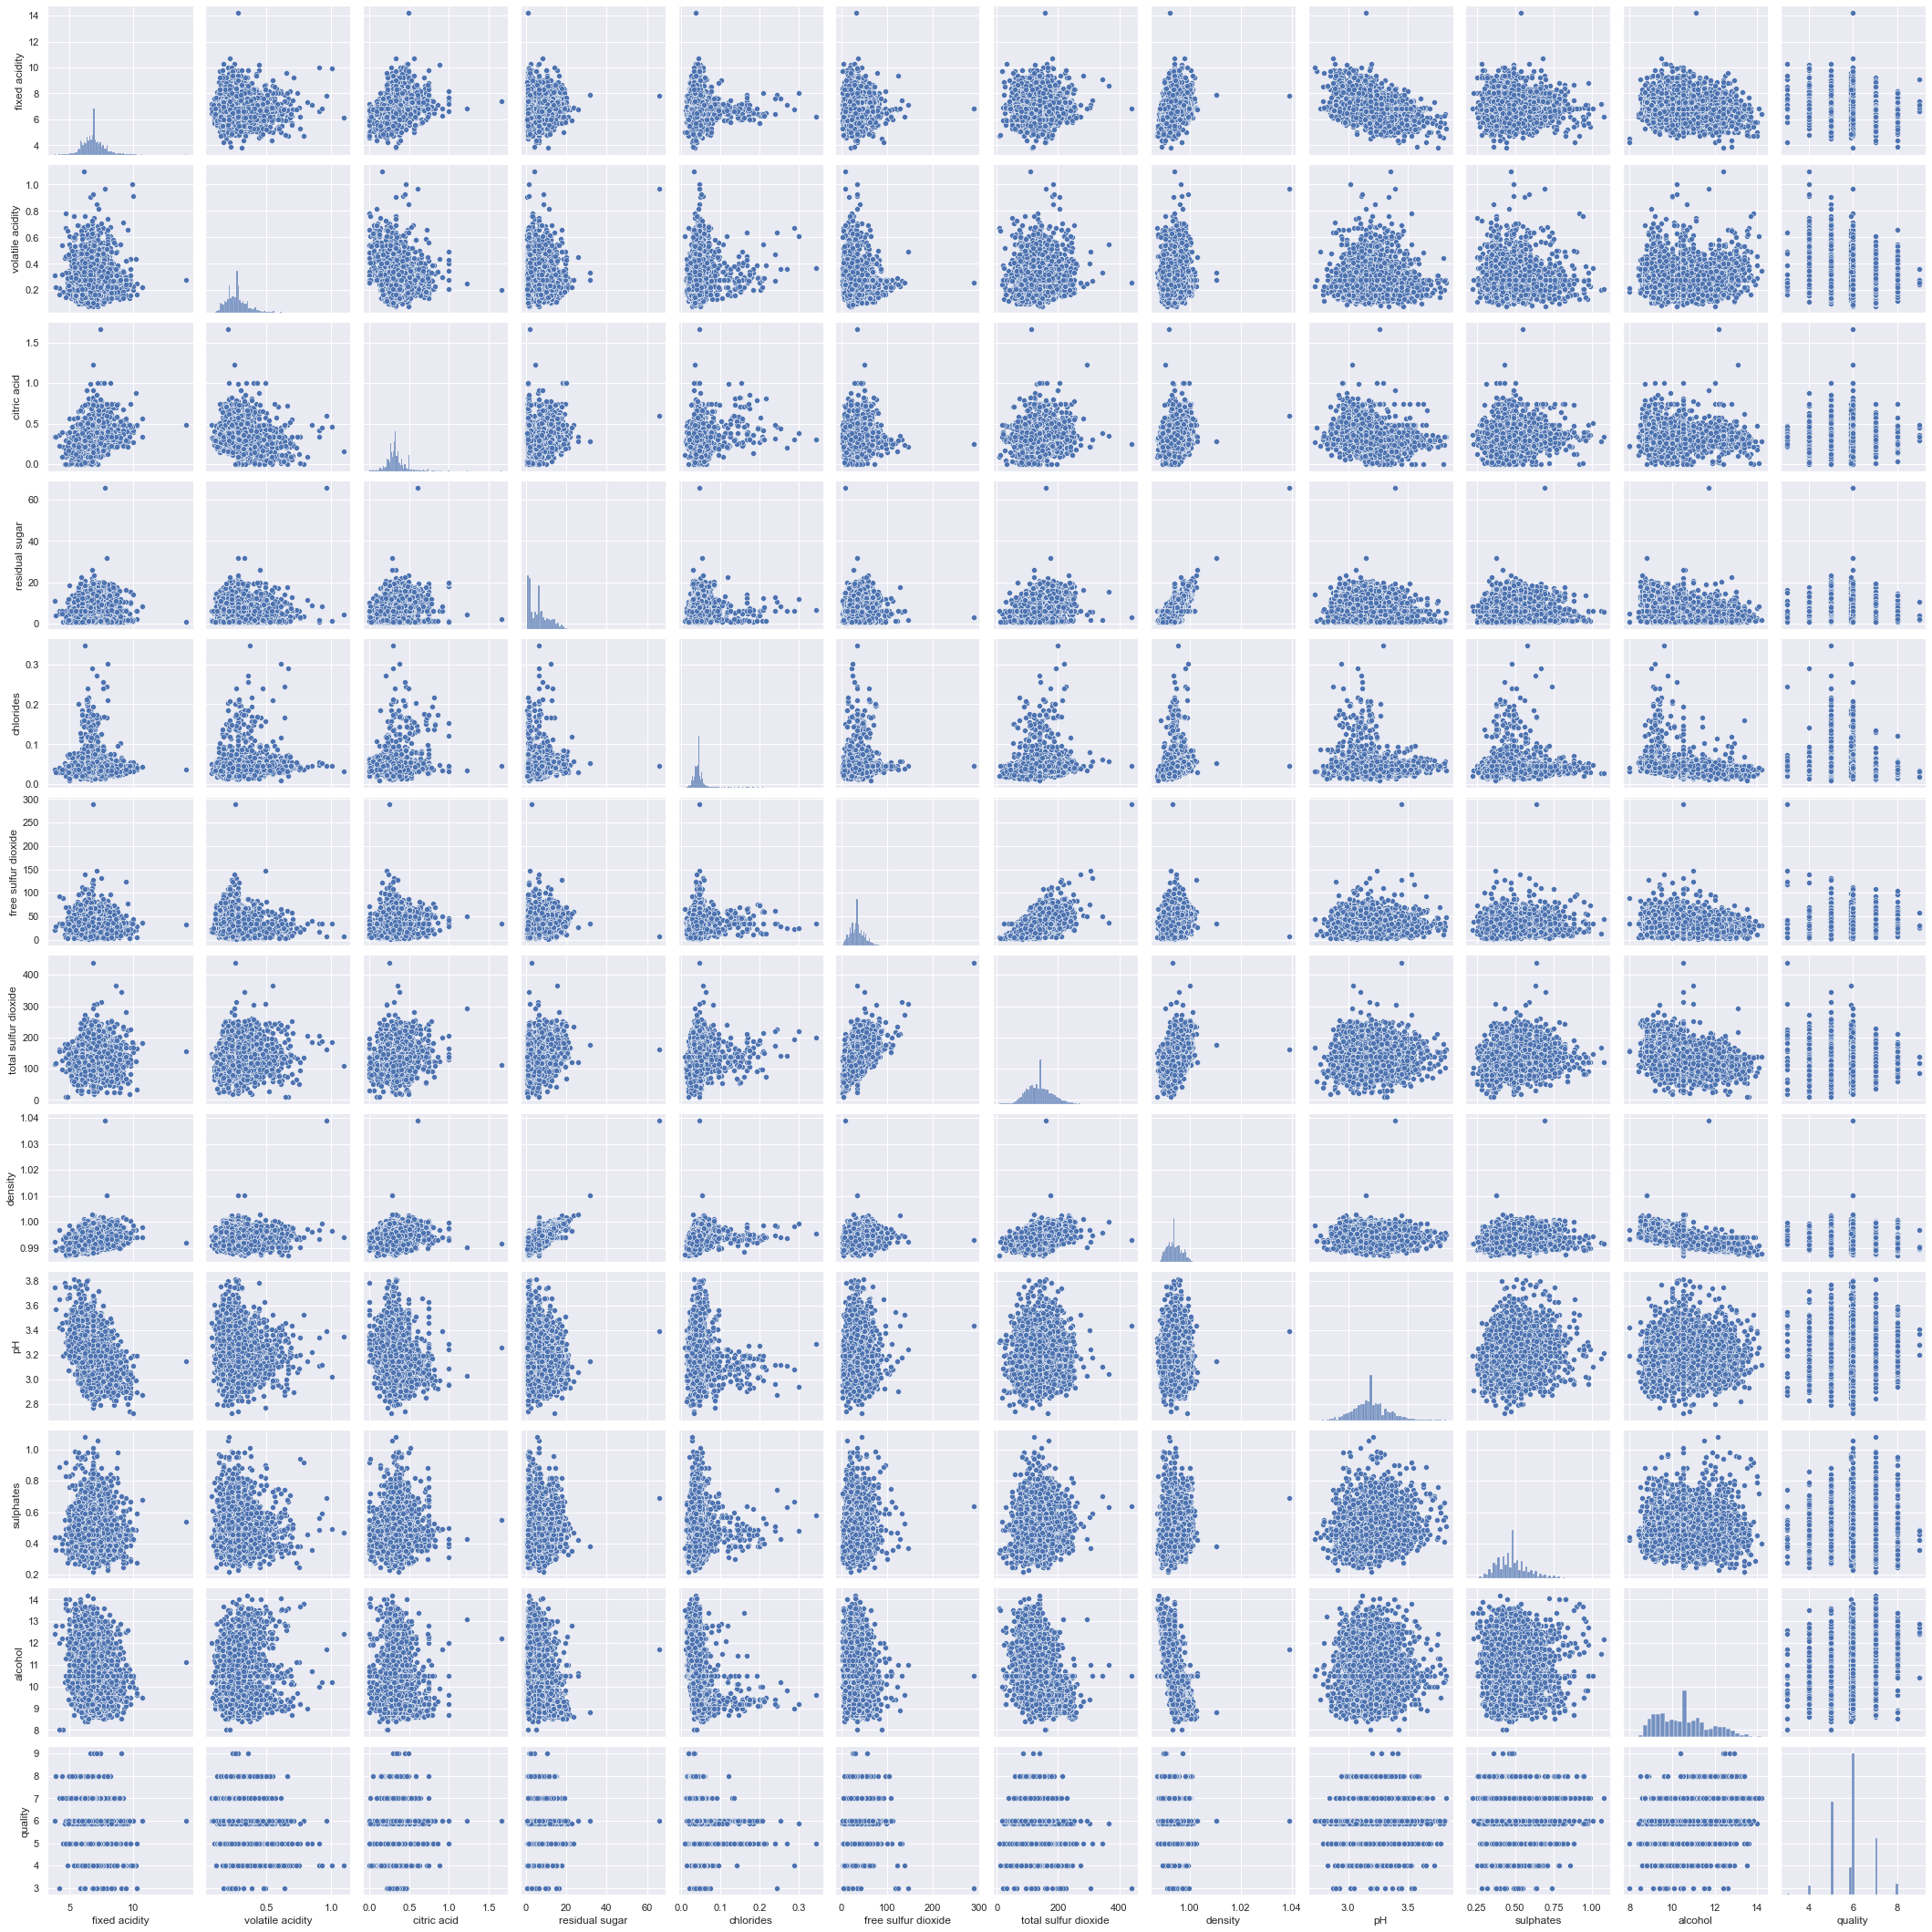

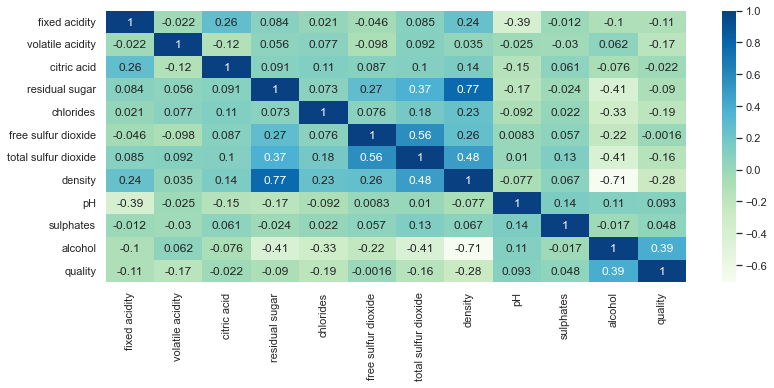

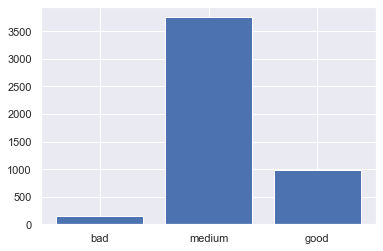

In [73]:
#VINHO BRANCO

dataset, header = loadFile("./winequality-white.csv")
header[11] = header[11].strip('\n')
redMissing = removeValues(dataset, 0.1)
redMissing = handleMissingValues(redMissing, 'mean')
#redMissing = handleMissingValues(redMissing, 'most_frequent')

'''
red1 = applyNormalization(dataset, 'l1')
print(red1)
red2 = applyNormalization(dataset, 'l2')
print(red2)
red3 = applyNormalization(dataset, 'max')
print(red3)

redRed = applyDataReduction(dataset)

redDisc = applyDiscretization(dataset)
'''
df = pd.DataFrame(dataset, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X = df.drop("wine classification", axis=1)
X = X.drop("quality", axis=1)

df = pd.DataFrame(redMissing, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X1 = df.drop("wine classification", axis=1)
X1 = X1.drop("quality", axis=1)

plotAllPearson(dataset, header)

decisionTree(df, X, "wine classification")

ourMLPClassifier(df, X, "wine classification")

knn(df, X, "wine classification")

kMeans(df, X, "wine classification", header)

dbscan(df, X, "wine classification")

agglomerativeClustering(df, X, "wine classification")

#print(ourMLPClassifier(df, X, "wine classification"))

#print(ourMLPClassifier(df, X1, "wine classification"))

sns_visualization = sns.pairplot(df)


#print(pearsonCorrelation(dataset, header, "fixed acidity"))

correlationMatrix(df)

#visualizePairOfFeatures(df, "fixed acidity", "citric acid")
#visualizePairOfFeatures(df, "fixed acidity", "density")
#visualizePairOfFeatures(df, "free sulfur dioxide", "total sulfur dioxide")

barPlotWineQuality(df)


# (fixed acidity, citric acid) (density, fixed acidity) (total sulfur dioxide, free sulfur dioxide)
# (quality, alcohol)


